In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import pandas as pd

from sklearn import model_selection

In [2]:
import bin_tree
import bin_forest
import g_boost

# ДЗ №6 Гладышев В.В.

## Задание № 1

Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев.

Сделать выводы о зависимости ошибки от этих параметров.

In [3]:
data = pd.read_csv("train.csv", sep=",")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [5]:
data.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [6]:
X = data.drop(['Id', 'mean_exam_points'], axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
dtypes: float64(10)
memory usage: 781.3 KB


In [7]:
X = X.values
X

array([[4.00e+01, 0.00e+00, 1.40e+03, ..., 0.00e+00, 1.00e+00, 0.00e+00],
       [4.80e+01, 4.00e+00, 2.85e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.90e+01, 0.00e+00, 1.20e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [3.40e+01, 1.00e+00, 1.25e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.30e+01, 3.00e+00, 1.10e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.50e+01, 0.00e+00, 1.45e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

In [8]:
y = data[['mean_exam_points']]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
mean_exam_points    10000 non-null float64
dtypes: float64(1)
memory usage: 78.2 KB


In [9]:
y = y.values.flatten()
y

array([63., 86., 53., ..., 58., 51., 59.])

In [10]:
class Leaf_Reg:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction 

In [11]:
def quality_reg(left_labels, right_labels, current_variance):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_variance - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [12]:
def find_best_split_reg(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_variance = np.var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = bin_tree.split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_reg(true_labels, false_labels, current_variance)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [13]:
def build_tree_reg_depth_lim(data, labels, depth_lim = 20, depth = 0):

    quality, t, index = find_best_split_reg(data, labels)
    #print("q: {} t: {} ind: {}".format(quality, t, index))

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or depth >= depth_lim:
        return Leaf_Reg(data, labels)

    true_data, false_data, true_labels, false_labels = bin_tree.split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_reg_depth_lim(true_data, true_labels, depth_lim, depth + 1)
    false_branch = build_tree_reg_depth_lim(false_data, false_labels, depth_lim, depth + 1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return bin_tree.Node(index, t, true_branch, false_branch)

In [14]:
def pred_item(item, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf_Reg):
        answer = node.prediction
        return answer

    if item[node.index] <= node.t:
        return pred_item(item, node.true_branch)
    else:
        return pred_item(item, node.false_branch)

In [15]:
def gb_predict_m(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta * coef * pred_item(x, tree) for tree, coef in zip(trees_list, coef_list)]) for x in X])

In [16]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [17]:
def bias(y, z):
    return (y - z)

In [18]:
def gb_fit_lt(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        #tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            #tree.fit(X_train, y_train)
            tree = build_tree_reg_depth_lim(X_train, y_train, max_depth)
            
            train_errors.append(mean_squared_error(y_train, gb_predict_m(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict_m(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict_m(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            #tree.fit(X_train, bias(y_train, target))
            tree = build_tree_reg_depth_lim(X_train, bias(y_train, target), max_depth)
            
            train_errors.append(mean_squared_error(y_train, gb_predict_m(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict_m(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [19]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(2, n_trees+1)
    plt.plot(list(range(2, n_trees+1)), train_err[1:], label='train error')
    plt.plot(list(range(2, n_trees+1)), test_err[1:], label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [20]:
def grid_mtr(n_trees_l, max_depth_l, eta_l, X, y):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)
    err_min = np.inf
    for tr in n_trees_l:
        for dp in max_depth_l:
            for et in eta_l:
                coefs = [1] * tr # для простоты примем коэффициенты равными 1
                trees, train_errors, test_errors = gb_fit_lt(tr, dp, X_train, X_test, y_train, y_test, coefs, et)
                train_prediction = gb_predict_m(X_train, trees, coefs, et)
                print(f'Ошибка алгоритма из {tr} деревьев глубиной {dp} с шагом {et} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')
                test_prediction = gb_predict_m(X_test, trees, coefs, et)
                err = mean_squared_error(y_test, test_prediction)
                print(f'Ошибка алгоритма из {tr} деревьев глубиной {dp} с шагом {et} на тестовой выборке: {err}')
                if err_min > err:
                    tr_b = tr
                    dp_b = dp
                    et_b = et
                    err_min = err
                get_error_plot(tr, train_errors, test_errors)
    print(f'Лучшие параметры: Ошибка алгоритма из {tr} деревьев глубиной {dp} с шагом {et} на тестовой выборке: {err_min}')
    return tr_b, dp_b, et_b

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 41.85032639612631
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тестовой выборке: 42.89189222152119


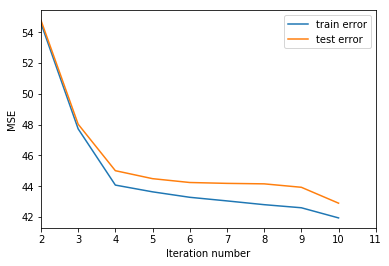

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.1 на тренировочной выборке: 572.8473411680155
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.1 на тестовой выборке: 574.893182109124


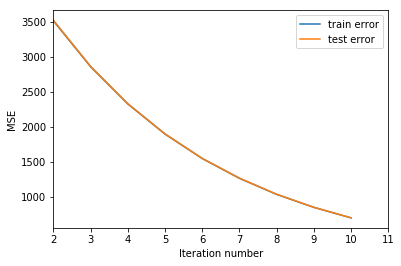

Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 1 на тренировочной выборке: 35.759331381826996
Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 1 на тестовой выборке: 43.89510402271741


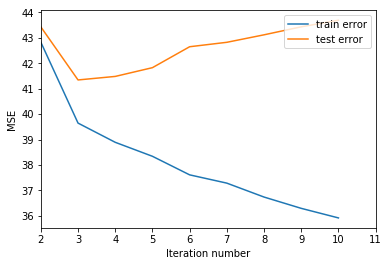

Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 0.1 на тренировочной выборке: 562.3994214587036
Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 563.976102338061


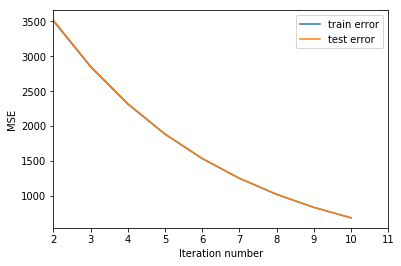

Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 36.94932232909171
Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 1 на тестовой выборке: 41.637309991357604


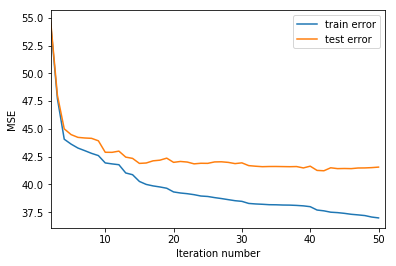

Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 0.1 на тренировочной выборке: 42.977999540063855
Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 0.1 на тестовой выборке: 43.224403649360234


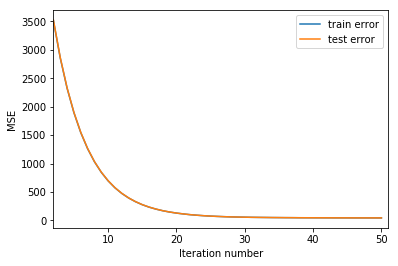

Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 1 на тренировочной выборке: 28.83805603982455
Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 1 на тестовой выборке: 48.107630015838254


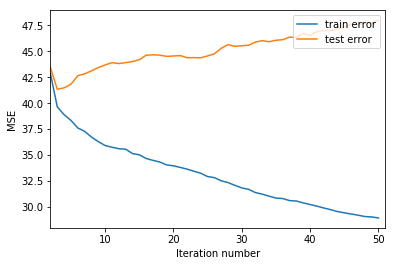

Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тренировочной выборке: 37.18012167521226
Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 40.0707502386174


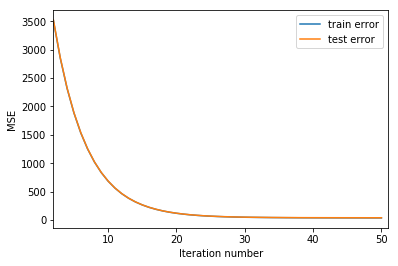

Лучшие параметры: Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 40.0707502386174


(50, 5, 0.1)

In [21]:
n_trees_l = [10, 50]
max_depth_l = [3, 5]
eta_l = [1, 0.1]

grid_mtr(n_trees_l, max_depth_l, eta_l, X, y)

In [22]:
def grid_btr(n_trees_l, max_depth_l, eta_l, X, y):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)
    err_min = np.inf
    for tr in n_trees_l:
        for dp in max_depth_l:
            for et in eta_l:
                coefs = [1] * tr # для простоты примем коэффициенты равными 1
                trees, train_errors, test_errors = g_boost.gb_fit(tr, dp, X_train, X_test, y_train, y_test, coefs, et)
                train_prediction = g_boost.gb_predict(X_train, trees, coefs, et)
                print(f'Ошибка алгоритма из {tr} деревьев глубиной {dp} с шагом {et} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')
                test_prediction = g_boost.gb_predict(X_test, trees, coefs, et)
                err = mean_squared_error(y_test, test_prediction)
                print(f'Ошибка алгоритма из {tr} деревьев глубиной {dp} с шагом {et} на тестовой выборке: {err}')
                if err_min > err:
                    tr_b = tr
                    dp_b = dp
                    et_b = et
                    err_min = err
                get_error_plot(tr, train_errors, test_errors)
    print(f'Лучшие параметры: Ошибка алгоритма из {tr} деревьев глубиной {dp} с шагом {et} на тестовой выборке: {err_min}')
    return tr_b, dp_b, et_b

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 41.24599325113339
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тестовой выборке: 43.716662856034894


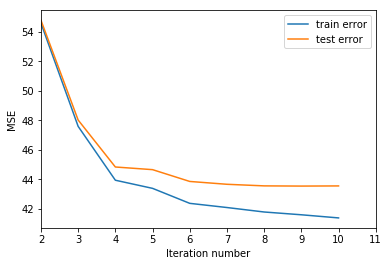

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.1 на тренировочной выборке: 572.8473411680234
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.1 на тестовой выборке: 574.8931821091321


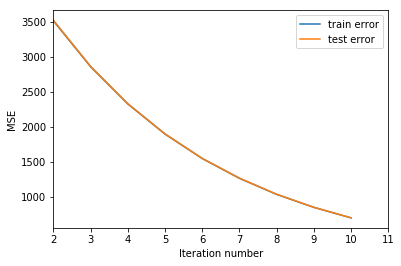

Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 1 на тренировочной выборке: 36.317551436659485
Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 1 на тестовой выборке: 43.3458976342949


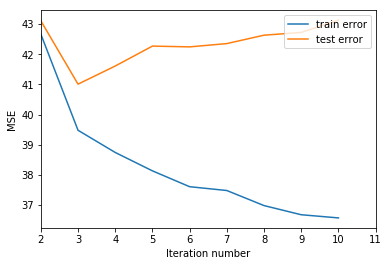

Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 0.1 на тренировочной выборке: 562.3123529551499
Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 563.909419194634


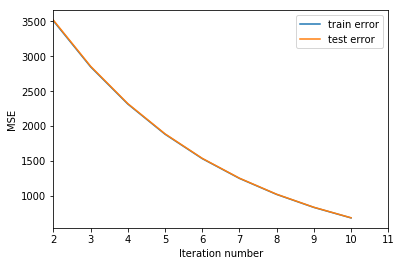

Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 37.063139167985284
Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 1 на тестовой выборке: 42.11186584577171


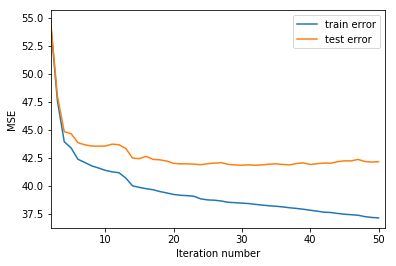

Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 0.1 на тренировочной выборке: 42.96130546767173
Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 0.1 на тестовой выборке: 43.13847290789959


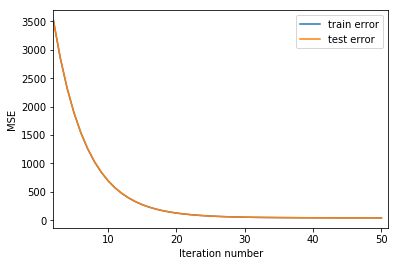

Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 1 на тренировочной выборке: 27.953186775678372
Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 1 на тестовой выборке: 50.98902882803359


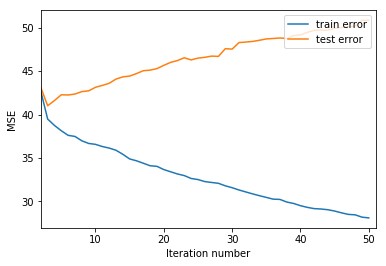

Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тренировочной выборке: 36.73407717923641
Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 39.8924806249734


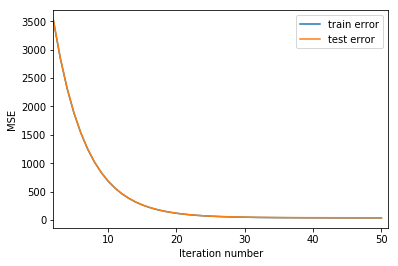

Лучшие параметры: Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 39.8924806249734


(50, 5, 0.1)

In [23]:
n_trees_l = [10, 50]
max_depth_l = [3, 5]
eta_l = [1, 0.1]

grid_btr(n_trees_l, max_depth_l, eta_l, X, y)

## Задание № 2

Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.

Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [42]:
def gb_fit_lt_half_div(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    half_n = X_train.shape[0] // 2
        
    for i in range(n_trees):
        if i % 2:
            b = 1
        else:
            b = 0
        beg_b = half_n*b
        end_b = half_n*(b+1)
        X_tr = X[beg_b : end_b, :]
        y_tr = y[beg_b : end_b]
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            
            tree = build_tree_reg_depth_lim(X_tr, y_tr, max_depth)

            train_errors.append(mean_squared_error(y_tr, gb_predict_m(X_tr, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict_m(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict_m(X_tr, trees, coefs, eta)

            # алгоритмы начиная со второго обучаем на сдвиг
            tree = build_tree_reg_depth_lim(X_tr, bias(y_tr, target), max_depth)

            train_errors.append(mean_squared_error(y_tr, gb_predict_m(X_tr, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict_m(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [43]:
def grid_mtr_hd(n_trees_l, max_depth_l, eta_l, X, y):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)
    err_min = np.inf
    for tr in n_trees_l:
        for dp in max_depth_l:
            for et in eta_l:
                coefs = [1] * tr # для простоты примем коэффициенты равными 1
                trees, train_errors, test_errors = gb_fit_lt_half_div(tr, dp, X_train, X_test, y_train, y_test, coefs, et)
                train_prediction = gb_predict_m(X_train, trees, coefs, et)
                print(f'Ошибка алгоритма из {tr} деревьев глубиной {dp} с шагом {et} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')
                test_prediction = gb_predict_m(X_test, trees, coefs, et)
                err = mean_squared_error(y_test, test_prediction)
                print(f'Ошибка алгоритма из {tr} деревьев глубиной {dp} с шагом {et} на тестовой выборке: {err}')
                if err_min > err:
                    tr_b = tr
                    dp_b = dp
                    et_b = et
                    err_min = err
                get_error_plot(tr, train_errors, test_errors)
    print(f'Лучшие параметры: Ошибка алгоритма из {tr} деревьев глубиной {dp} с шагом {et} на тестовой выборке: {err_min}')
    return tr_b, dp_b, et_b

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 42.70422172191151
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тестовой выборке: 41.539402682141215


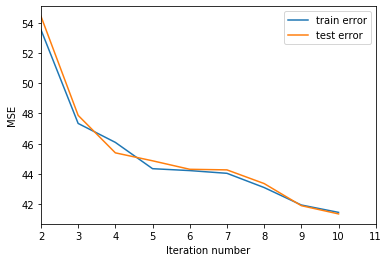

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.1 на тренировочной выборке: 571.9243308818674
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.1 на тестовой выборке: 573.9409296079313


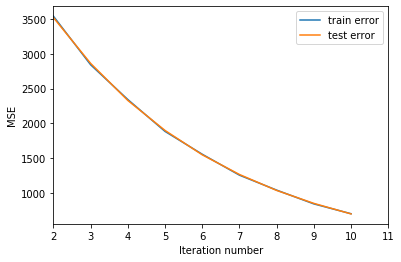

Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 1 на тренировочной выборке: 41.473279828165296
Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 1 на тестовой выборке: 41.03750497923822


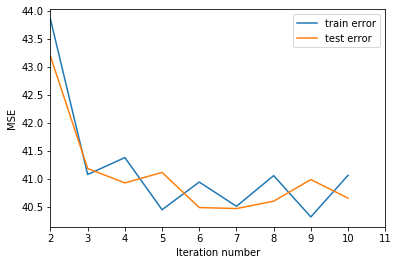

Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 0.1 на тренировочной выборке: 563.2971153354056
Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 565.1061224587446


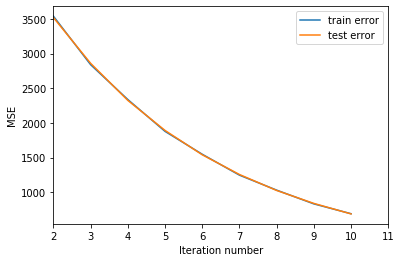

Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 42.21129533444066
Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 1 на тестовой выборке: 41.23236827909047


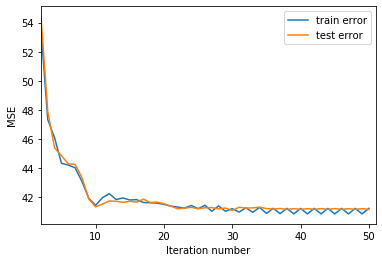

Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 0.1 на тренировочной выборке: 42.74924525941889
Ошибка алгоритма из 50 деревьев глубиной 3 с шагом 0.1 на тестовой выборке: 42.13713430422383


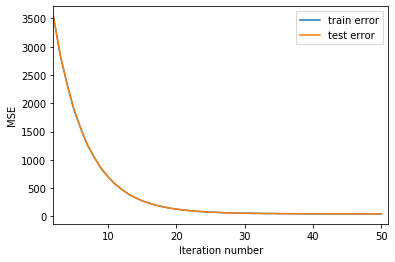

Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 1 на тренировочной выборке: 42.02150741316231
Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 1 на тестовой выборке: 40.15284277899528


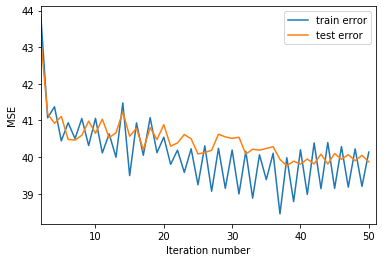

Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тренировочной выборке: 38.94318950470569
Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 37.38443271073822


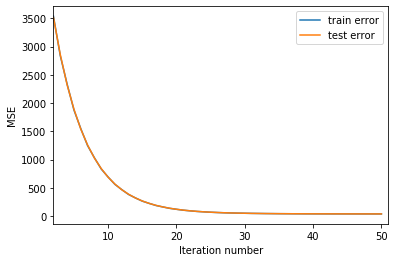

Лучшие параметры: Ошибка алгоритма из 50 деревьев глубиной 5 с шагом 0.1 на тестовой выборке: 37.38443271073822


(50, 5, 0.1)

In [44]:
n_trees_l = [10, 50]
max_depth_l = [3, 5]
eta_l = [1, 0.1]

grid_mtr_hd(n_trees_l, max_depth_l, eta_l, X, y)